<a href="https://colab.research.google.com/github/toast210/PCOS-detection/blob/main/pcos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Necessary Libraries for the project**

In [1]:
import time
import shutil
import pathlib
import itertools
from PIL import Image
import pandas as pd
import numpy  as np
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, roc_auc_score


In [2]:
import os

# Importing data


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ibadeus/pcos-xai-ultrasound-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pcos-xai-ultrasound-dataset' dataset.
Path to dataset files: /kaggle/input/pcos-xai-ultrasound-dataset


In [7]:
base_path = "/kaggle/input/pcos-xai-ultrasound-dataset/PCOS/"
categories = ["infected", "noninfected"]

# Data Handling
I am thinking of iterating through data and making a pandas dataframe which has file path and lablel them as infected or not infected

In [9]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [10]:
df.head()

,image_path,label
0,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,infected
1,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,infected
2,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,infected
3,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,infected
4,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,infected


In [11]:
df.tail()

,image_path,label
11779,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,noninfected
11780,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,noninfected
11781,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,noninfected
11782,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,noninfected
11783,/kaggle/input/pcos-xai-ultrasound-dataset/PCOS...,noninfected


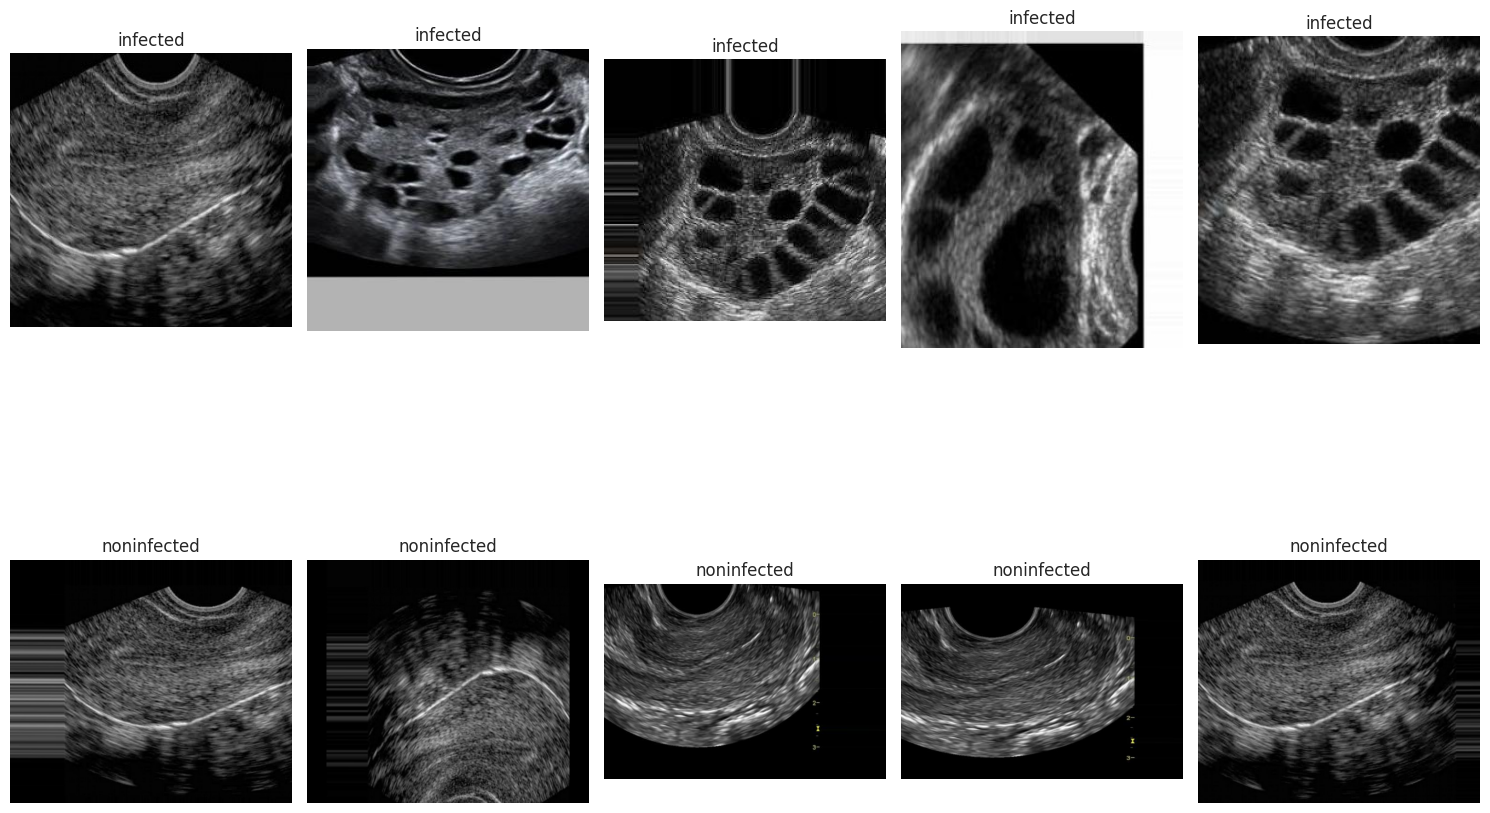

In [12]:
num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])

In [14]:
df = df[['image_path', 'category_encoded']]

In [15]:
from sklearn.utils import resample

max_count = df['category_encoded'].value_counts().max()

dfs = []
for category in df['category_encoded'].unique():
    class_subset = df[df['category_encoded'] == category]
    class_upsampled = resample(class_subset,
                               replace=True,
                               n_samples=max_count,
                               random_state=42)
    dfs.append(class_upsampled)

df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
df_balanced['category_encoded'].value_counts()

,count
category_encoded,
0,6784
1,6784


In [17]:
df_resampled = df_balanced
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(int)

In [18]:
print(df["category_encoded"].unique())

[0 1]


# Creating training, testing and validating dataset
Now since we only have a single dataset, we are going to do a train validate test method rather than train test for better results

In [19]:
train_df, temp_df = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']
)

valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df['category_encoded']
)

# Parameters

In [20]:

LR = 1e-4
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the model
I am using Densenet121


In [21]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class UltrasoundDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "category_encoded"]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [22]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [23]:
from torch.utils.data import DataLoader

train_dataset = UltrasoundDataset(train_df, transform=train_transforms)
val_dataset   = UltrasoundDataset(valid_df, transform=val_transforms)
test_dataset  = UltrasoundDataset(test_df, transform=val_transforms)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)  # binary classes
model = model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 103MB/s]


In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training the model

In [26]:
# For tracking
history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    # ---- Training ----
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100. * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    # Save history
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")


Epoch 1/15 | Train Loss: 0.0816, Acc: 96.93% | Val Loss: 0.0396, Acc: 98.31%
Epoch 2/15 | Train Loss: 0.0445, Acc: 98.33% | Val Loss: 0.0283, Acc: 99.04%
Epoch 3/15 | Train Loss: 0.0369, Acc: 98.65% | Val Loss: 0.0166, Acc: 99.48%
Epoch 4/15 | Train Loss: 0.0318, Acc: 98.97% | Val Loss: 0.0194, Acc: 99.78%
Epoch 5/15 | Train Loss: 0.0239, Acc: 99.19% | Val Loss: 0.0253, Acc: 98.89%
Epoch 6/15 | Train Loss: 0.0222, Acc: 99.26% | Val Loss: 0.1277, Acc: 96.46%
Epoch 7/15 | Train Loss: 0.0221, Acc: 99.21% | Val Loss: 0.0513, Acc: 98.67%
Epoch 8/15 | Train Loss: 0.0155, Acc: 99.44% | Val Loss: 0.0289, Acc: 98.89%
Epoch 9/15 | Train Loss: 0.0165, Acc: 99.41% | Val Loss: 0.0090, Acc: 99.63%
Epoch 10/15 | Train Loss: 0.0194, Acc: 99.39% | Val Loss: 0.0143, Acc: 99.34%
Epoch 11/15 | Train Loss: 0.0116, Acc: 99.69% | Val Loss: 0.0215, Acc: 99.26%
Epoch 12/15 | Train Loss: 0.0142, Acc: 99.44% | Val Loss: 0.0138, Acc: 99.41%
Epoch 13/15 | Train Loss: 0.0125, Acc: 99.59% | Val Loss: 0.0075, Acc: 99

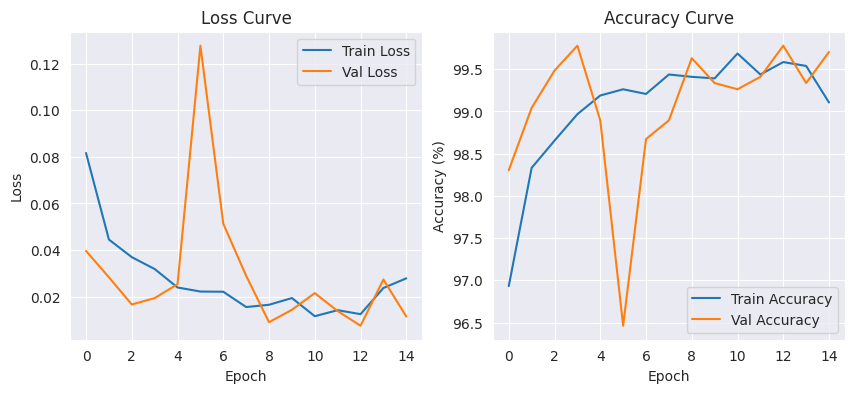

In [27]:
# Plot Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [28]:
model.eval()
y_true, y_pred, y_score = [], [], []

In [29]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # prob for "infected"

        _, preds = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

In [30]:

print(classification_report(y_true, y_pred, target_names=["Non-infected", "Infected"]))
print("ROC-AUC:", roc_auc_score(y_true, y_score))

              precision    recall  f1-score   support

Non-infected       1.00      1.00      1.00       679
    Infected       1.00      1.00      1.00       678

    accuracy                           1.00      1357
   macro avg       1.00      1.00      1.00      1357
weighted avg       1.00      1.00      1.00      1357

ROC-AUC: 1.0


In [31]:
torch.save(model.state_dict(), "pcos_model.pth")
print("✅ Model saved as pcos_model.pth")

✅ Model saved as pcos_model.pth
